In [21]:
import numpy as np
import pandas as pd
import gc
import xgboost as xgb
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score, recall_score, RocCurveDisplay


In [22]:
df = pd.read_parquet("processed_data/agg_data_preprocess_2.gzip")
df

,B_1_first,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_10_first,B_10_mean,B_10_std,B_10_min,...,D_126_nunique,D_63_count,D_63_last,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_68_count,D_68_last,D_68_nunique
0,0.008728,0.012009,0.006546,0.001930,0.021652,0.009384,0.096191,0.270264,0.181835,0.096191,...,1,13,CR,1,13,O,1,13,6.0,1
1,0.025787,0.025650,0.027750,0.006710,0.109619,0.034698,0.302734,0.298828,0.003044,0.293945,...,1,13,CO,1,13,O,1,13,6.0,1
2,0.001472,0.004387,0.002786,0.001472,0.009995,0.004284,0.222168,0.273682,0.052867,0.162109,...,1,13,CO,1,13,R,1,13,6.0,1
3,0.070312,0.059875,0.080538,0.005909,0.280029,0.012566,0.297852,0.306641,0.079525,0.192993,...,1,13,CO,1,13,O,1,13,3.0,3
4,0.003433,0.005939,0.002475,0.000776,0.009804,0.007679,0.058777,0.100342,0.074579,0.044739,...,1,13,CO,1,13,O,1,13,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,0.006084,0.029175,0.014286,0.006084,0.051941,0.028519,0.370605,0.591309,0.373031,0.366211,...,1,13,CO,1,13,U,1,13,6.0,1
458909,0.431396,0.368408,0.051249,0.292480,0.452148,0.292480,0.037628,0.042603,0.016051,0.021011,...,1,13,CO,1,13,R,1,13,6.0,1
458910,0.063904,0.043030,0.040382,0.013000,0.162476,0.020569,0.302002,0.268555,0.069366,0.092590,...,1,13,CO,1,13,U,1,13,5.0,1
458911,0.003494,0.018158,0.009637,0.000281,0.030563,0.015839,0.092163,0.039734,0.041169,0.006924,...,1,13,CO,1,13,U,2,13,3.0,2


Dataset has many features, is it possible to reduce the feature space?

In [23]:
# these features are derived from Xgboost model's feature importance
most_important_features = ["P_2_min","P_2_last", "P_2_mean", "B_1_last", "D_48_last",
                            "D_44_last", "B_2_last", "B_3_last_lag_sub", "R_1_mean", "P_2_last_lag_div", "B_7_mean",
                            "D_51_last", "D_56_mean", "B_10_last", "R_1_std", "D_44_max", "D_56_max", "B_23_last", "R_2_last", "B_8_mean",
                            "R_27_min", "D_41_last_lag_sub", "B_3_last", "D_45_first", "B_4_last_lag_sub", "D_77_mean"
                            ]

In [24]:
data = df[most_important_features]
target = pd.read_feather("train_labels.ftr")["target"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(371718, 26)
(41303, 26)
(45892, 26)


# Xgboost with most important features

In [26]:
xgboost_parameters = {
    'verbosity': 1,
    'max_depth':4, 
    'learning_rate':0.04, 
    'subsample':0.71,
    'colsample_bytree':0.72, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'enable_categorical': True
    }

In [27]:
xgb_clf = xgb.XGBClassifier(**xgboost_parameters)
cv_results = cross_validate(xgb_clf, X_train, y_train, cv=5, scoring=('roc_auc', 'precision', 'recall'), return_train_score=True)

In [28]:
print("Precision on validation set: " , np.mean(cv_results['test_precision']))
print("Recall on validation set: " , np.mean(cv_results['test_recall']))
print("Roc_auc on validation set: " , np.mean(cv_results['test_roc_auc']))
print("---------------------")
print("Precision on train set: " , np.mean(cv_results['train_precision']))
print("Recall on train set: " , np.mean(cv_results['train_recall']))
print("Roc_auc on train set: " , np.mean(cv_results['train_roc_auc']))


Precision on validation set:  0.7835950214603506
Recall on validation set:  0.7780578189835536
Roc_auc on validation set:  0.9483696732706763
---------------------
Precision on train set:  0.7851413967418096
Recall on train set:  0.7791209023907953
Roc_auc on train set:  0.9492421114635926


In [29]:
def display_metrics(predictor,y_true, y_pred_labels, y_pred_score):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    accuracy = accuracy_score(y_true, y_pred_labels)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_pred_labels)
    print("Precision score: ", precision)
    recall = recall_score(y_true, y_pred_labels)
    print("Recall score: ", recall)
    f1 = f1_score(y_true, y_pred_labels)
    print("F1 score: ", f1)
    rocauc = roc_auc_score(y_true, y_pred_labels)
    print("roc_auc score: ", rocauc)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)
    fpr, tpr, _ = roc_curve(y_true, y_pred_score[:, 1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=predictor.classes_).plot(ax=ax1)

In [30]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.72,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Accuracy:  0.8872720718394052
Precision score:  0.7855332076262309
Recall score:  0.7777362913179211
F1 score:  0.781615305638508
roc_auc score:  0.8516852077110417


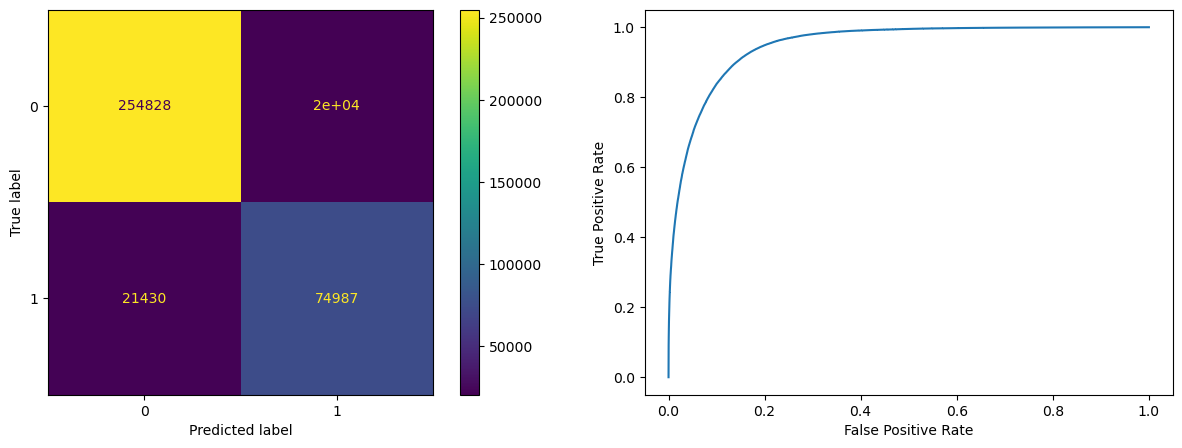

In [31]:
pred_train = xgb_clf.predict(X_train)
pred_proba_train = xgb_clf.predict_proba(X_train)
display_metrics(xgb_clf, y_train, pred_train, pred_proba_train)

Accuracy:  0.8886298265492897
Precision score:  0.7893690579083837
Recall score:  0.7735241805708478
F1 score:  0.7813663002096077
roc_auc score:  0.851013227149147


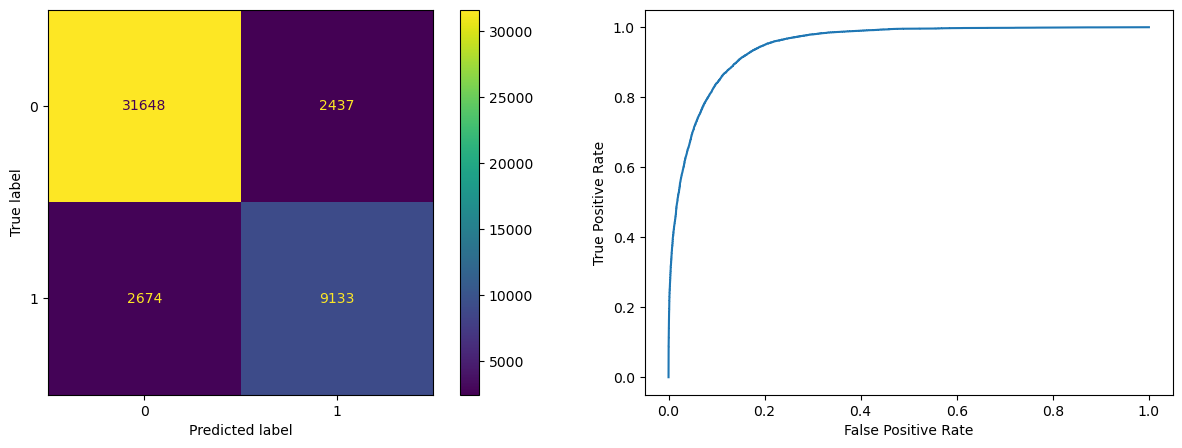

In [32]:
pred_test = xgb_clf.predict(X_test)
pred_prob = xgb_clf.predict_proba(X_test)
display_metrics(xgb_clf, y_test, pred_test, pred_prob)

In [33]:
xgb_clf.save_model("reduced_xgboost.json")

## XGboost Hyperparameter Optimization

In [34]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'alpha' : hp.uniform('alpha', 0, 10),
        'lambda' : hp.uniform('lambda', 1,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'subsample': hp.uniform('subsample', 0.5, 1),
        'eta': hp.uniform('eta', 0.1, 1)
    }

In [35]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    alpha = int(space['alpha']), eta=space['eta'], subsample=space['subsample'], 
                    reg_lambda=space['lambda'],
                    min_child_weight=int(space['min_child_weight']), enable_categorical=True,
                    tree_method='gpu_hist', eval_metric="auc",  early_stopping_rounds=10,
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, 
           verbose=False)
    

    pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [36]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.884390964336731                                      
SCORE:                                                                           
0.8844635982858388                                                               
SCORE:                                                                            
0.8853836283078711                                                                
SCORE:                                                                            
0.8843183303876232                                                                
SCORE:                                                                            
0.8844635982858388                                                                
SCORE:                                                                            
0.8853594169915018                                                                
SCORE:                                                      

In [37]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 9.971594688486395, 'colsample_bytree': 0.9566830983079153, 'eta': 0.8142847264991369, 'gamma': 5.1991437226955926, 'lambda': 1.413802584679472, 'max_depth': 8.0, 'min_child_weight': 6.0, 'subsample': 0.8355345421036986}


In [38]:
best_xgboost_parameters = {
    'alpha': 9.4572,
    'colsample_bytree': 0.6190,
    'eta': 0.3873,
    'gamma': 3.2264,
    'lambda': 4.0406,
    'max_depth': 12,
    'min_child_weight': 0.0,
    'subsample': 0.9290,
    'n_estimators': 180,
    'enable_categorical':True,
    'tree_method':'gpu_hist',
    'eval_metric': 'auc',
}

In [39]:
best_xgb_clf =xgb.XGBClassifier(**best_xgboost_parameters)
best_xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=9.4572, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.619,
              early_stopping_rounds=None, enable_categorical=True, eta=0.3873,
              eval_metric='auc', feature_types=None, gamma=3.2264, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=4.0406,
              learning_rate=0.387300014, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
              min_child_weight=0.0, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=0, ...)

Accuracy:  0.889784711932363
Precision score:  0.7903295190570421
Recall score:  0.7780130431100195
F1 score:  0.7841229193341869
roc_auc score:  0.8532576584187328


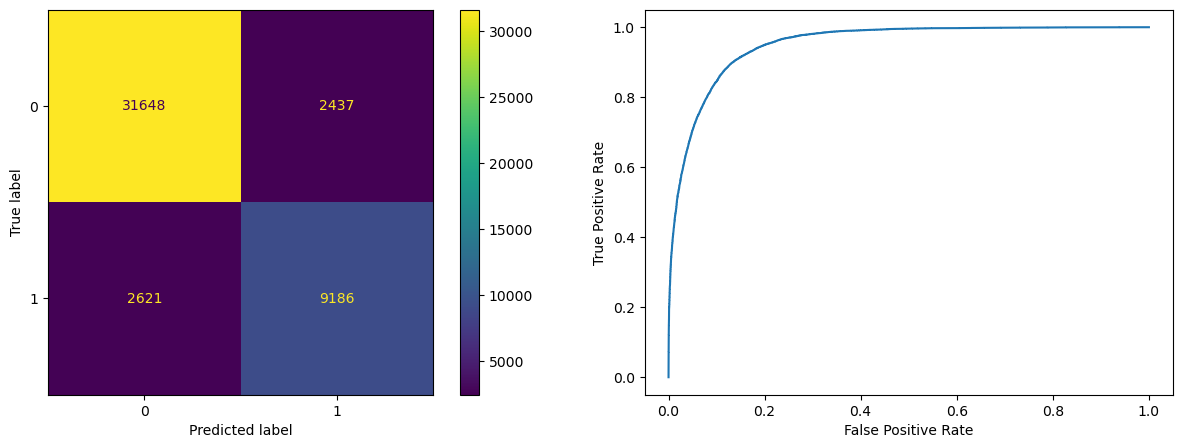

In [40]:
pred_test = best_xgb_clf.predict(X_test)
pred_prob = best_xgb_clf.predict_proba(X_test)
display_metrics(best_xgb_clf, y_test, pred_test, pred_prob)

# Neural Network with most important features

In [41]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

c:\Users\asude\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tabnet cannot work with missing or categorical data. Hence, feature processing is required.

In [42]:
X_train.nunique()

P_2_min               11763
P_2_last              10646
P_2_mean               6848
B_1_last              13994
D_48_last             13804
D_44_last              8222
B_2_last              11671
B_3_last_lag_sub      23118
R_1_mean               9882
P_2_last_lag_div      12085
B_7_mean               8786
D_51_last              8078
D_56_mean              9919
B_10_last             12481
R_1_std              366046
D_44_max               3015
D_56_max               9373
B_23_last             12264
R_2_last               8202
B_8_mean               3090
R_27_min               8453
D_41_last_lag_sub     21801
B_3_last              14627
D_45_first            13286
B_4_last_lag_sub      20860
D_77_mean             10731
dtype: int64

All features are numeric, no need to one hot code.

In [43]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer


median_imputer = MeanMedianImputer(imputation_method='median')
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_val = median_imputer.transform(X_val)
X_test = median_imputer.transform(X_test)


In [44]:
X_train.isna().sum().sum()

0

In [45]:
model = TabNetClassifier(   n_d = 12,
                            n_a = 12,
                            n_steps = 3, #default
                            gamma = 1.3, #default
                            n_independent = 2, #default
                            n_shared = 2, #default
                            momentum = 0.02, #default
                            clip_value = None, #default
                            lambda_sparse = 1e-3,
                            optimizer_fn = torch.optim.Adam, #default
                            optimizer_params = dict(lr = 2e-2, weight_decay=1e-3),
                            scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                            scheduler_params = {'T_0':5,
                                                 'eta_min':1e-4,
                                                 'T_mult':1,
                                                 'last_epoch':-1},
                            mask_type = 'entmax',
                        )

c:\Users\asude\anaconda3\envs\ML\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [46]:
model.fit(np.array(X_train),
              np.array(y_train.values.ravel()),
              eval_set = [(np.array(X_val), np.array(y_val.values.ravel()))],
              max_epochs = 1000,
              patience = 25,
              batch_size = 1024,
              eval_metric = ['accuracy', 'auc']) # Last metric is used for early stopping
    

epoch 0  | loss: 0.28003 | val_0_accuracy: 0.88204 | val_0_auc: 0.94555 |  0:00:19s
epoch 1  | loss: 0.26088 | val_0_accuracy: 0.88265 | val_0_auc: 0.94625 |  0:00:38s
epoch 2  | loss: 0.25899 | val_0_accuracy: 0.88471 | val_0_auc: 0.94674 |  0:00:57s
epoch 3  | loss: 0.2568  | val_0_accuracy: 0.88347 | val_0_auc: 0.94695 |  0:01:16s
epoch 4  | loss: 0.25491 | val_0_accuracy: 0.88538 | val_0_auc: 0.94766 |  0:01:36s
epoch 5  | loss: 0.25974 | val_0_accuracy: 0.87543 | val_0_auc: 0.9444  |  0:01:57s
epoch 6  | loss: 0.25971 | val_0_accuracy: 0.88185 | val_0_auc: 0.94688 |  0:02:18s
epoch 7  | loss: 0.25838 | val_0_accuracy: 0.88471 | val_0_auc: 0.94667 |  0:02:42s
epoch 8  | loss: 0.25671 | val_0_accuracy: 0.88548 | val_0_auc: 0.94712 |  0:03:07s
epoch 9  | loss: 0.25502 | val_0_accuracy: 0.88558 | val_0_auc: 0.94761 |  0:03:33s
epoch 10 | loss: 0.25981 | val_0_accuracy: 0.88454 | val_0_auc: 0.94641 |  0:03:59s
epoch 11 | loss: 0.25937 | val_0_accuracy: 0.88258 | val_0_auc: 0.94658 |  0

c:\Users\asude\anaconda3\envs\ML\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


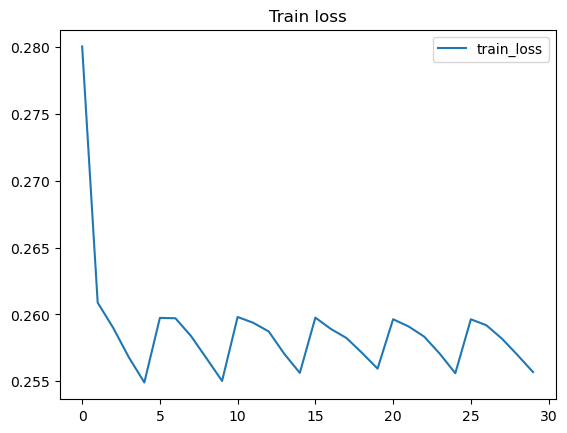

In [47]:
stats = pd.DataFrame()
stats['train_loss'] = model.history['loss']


for i in stats.filter(like='train', axis=1).columns.tolist():
    plt.plot(stats[i], label=str(i))
plt.title('Train loss')
plt.legend()  

Accuracy:  0.8891527935152096
Precision score:  0.7949438202247191
Recall score:  0.7670026255611078
F1 score:  0.7807233070390964
roc_auc score:  0.8492340397865682


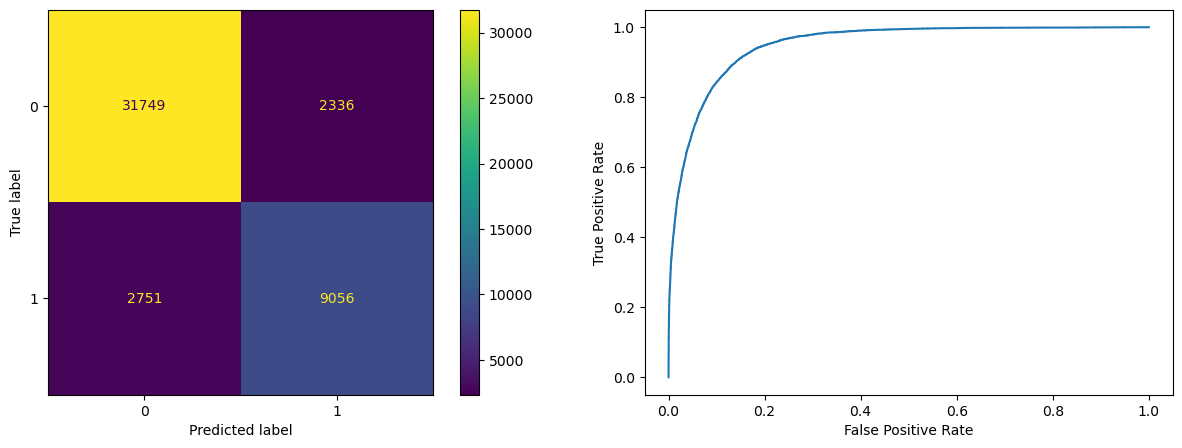

In [48]:
tabnet_pred_proba = model.predict_proba(np.array(X_test))
tabnet_pred = model.predict(np.array(X_test))
display_metrics(model, y_test, tabnet_pred, tabnet_pred_proba)

In [49]:
model.save_model("tabnet_model")

Successfully saved model at tabnet_model.zip


'tabnet_model.zip'